In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
from google.colab import files
uploaded = files.upload()

Saving modis_flood_features_cleaned_v1.1.csv to modis_flood_features_cleaned_v1.1 (1).csv


In [17]:
# Load Dataset
df = pd.read_csv('modis_flood_features_cleaned_v1.1.csv', parse_dates=['date'])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472156 entries, 0 to 1472155
Data columns (total 16 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   date            1472156 non-null  datetime64[ns]
 1   lon             1472156 non-null  float64       
 2   lat             1472156 non-null  float64       
 3   flooded         1472156 non-null  float64       
 4   jrc_perm_water  1472156 non-null  float64       
 5   precip_1d       1472156 non-null  float64       
 6   precip_3d       1472156 non-null  float64       
 7   NDVI            1472156 non-null  float64       
 8   NDWI            1472156 non-null  float64       
 9   landcover       1472156 non-null  float64       
 10  elevation       1472156 non-null  float64       
 11  slope           1472156 non-null  float64       
 12  aspect          1472156 non-null  float64       
 13  upstream_area   1472156 non-null  float64       
 14  TWI             14

In [19]:
# Preprocessing
X = df.drop(columns=['date', 'target', 'flooded','jrc_perm_water'])
y = df['target']
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Normalisasi
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape untuk LSTM
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, stratify=y, random_state=42)

In [20]:
#LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3)

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=15, batch_size=512, callbacks=[early_stop], verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.9652 - loss: 0.1528 - val_accuracy: 0.9667 - val_loss: 0.0885
Epoch 2/15
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9665 - loss: 0.0887 - val_accuracy: 0.9674 - val_loss: 0.0843
Epoch 3/15
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.9675 - loss: 0.0843 - val_accuracy: 0.9684 - val_loss: 0.0807
Epoch 4/15
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9683 - loss: 0.0803 - val_accuracy: 0.9693 - val_loss: 0.0776
Epoch 5/15
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.9691 - loss: 0.0776 - val_accuracy: 0.9700 - val_loss: 0.0753
Epoch 6/15
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.9695 - loss: 0.0762 - val_accuracy: 0.9701 - val_loss: 0.0739
Epoch 7/15
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9703 - loss: 0.0741 - val_accuracy: 0.9701 - val_loss: 0.0736
Epoch 8/15
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.9704 - l

In [21]:
#Evaluasi LSTM
y_pred = (model.predict(X_test) > 0.5).astype('int')
print("\n=== Evaluasi LSTM baseline ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

9201/9201 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step

=== Evaluasi LSTM baseline ===
[[283329   1159]
 [  6818   3126]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    284488
           1       0.73      0.31      0.44      9944

    accuracy                           0.97    294432
   macro avg       0.85      0.66      0.71    294432
weighted avg       0.97      0.97      0.97    294432



In [22]:
# LSTM + SMOTE
X_smote_flat = X_scaled
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_smote_flat, y)

X_resampled_3d = X_resampled.reshape((X_resampled.shape[0], 1, X_resampled.shape[1]))

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_resampled_3d, y_resampled, test_size=0.2, random_state=42)

model_sm = Sequential()
model_sm.add(LSTM(64, input_shape=(X_train_s.shape[1], X_train_s.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model_sm.add(Dense(32, activation='relu'))
model_sm.add(Dense(1, activation='sigmoid'))

model_sm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_sm.fit(X_train_s, y_train_s, validation_data=(X_test_s, y_test_s),
             epochs=15, batch_size=512, callbacks=[early_stop], verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
4446/4446 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - accuracy: 0.8666 - loss: 0.3340 - val_accuracy: 0.9106 - val_loss: 0.2371
Epoch 2/15
4446/4446 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9118 - loss: 0.2337 - val_accuracy: 0.9153 - val_loss: 0.2257
Epoch 3/15
4446/4446 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.9171 - loss: 0.2207 - val_accuracy: 0.9198 - val_loss: 0.2133
Epoch 4/15
4446/4446 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.9208 - loss: 0.2110 - val_accuracy: 0.9206 - val_loss: 0.2105
Epoch 5/15
4446/4446 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.9235 - loss: 0.2046 - val_accuracy: 0.9261 - val_loss: 0.1976
Epoch 6/15
4446/4446 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9265 - loss: 0.1973 - val_accuracy: 0.9282 - val_loss: 0.1922
Epoch 7/15
4446/4446 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - accuracy: 0.9289 - loss: 0.1913 - val_accuracy: 0.9299 - val_loss: 0.1890
Epoch 8/15
4446/4446 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9305 - loss: 0

In [23]:
# Evaluasi LSTM + SMOTE
y_pred_sm = (model_sm.predict(X_test_s) > 0.5).astype('int')
print("\n=== Evaluasi LSTM Dengan SMOTE ===")
print(confusion_matrix(y_test_s, y_pred_sm))
print(classification_report(y_test_s, y_pred_sm))

17781/17781 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step

=== Evaluasi LSTM Dengan SMOTE ===
[[263329  21034]
 [ 15556 269056]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94    284363
           1       0.93      0.95      0.94    284612

    accuracy                           0.94    568975
   macro avg       0.94      0.94      0.94    568975
weighted avg       0.94      0.94      0.94    568975



In [24]:
from imblearn.under_sampling import RandomUnderSampler
#LSTM + Undersampling
X_train_2d, X_test_2d, y_train_under, y_test_under = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)

rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train_2d, y_train_under)

X_under_3d = X_under.reshape((X_under.shape[0], 1, X_under.shape[1]))

model_under = Sequential()
model_under.add(LSTM(64, input_shape=(X_under_3d.shape[1], X_under_3d.shape[2])))
model_under.add(Dense(1, activation='sigmoid'))

model_under.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop_under = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_under = model_under.fit(
    X_under_3d, y_under,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop_under],
    verbose=2
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1989/1989 - 10s - 5ms/step - accuracy: 0.8134 - loss: 0.4001 - val_accuracy: 0.8524 - val_loss: 0.3948
Epoch 2/50
1989/1989 - 11s - 5ms/step - accuracy: 0.8736 - loss: 0.3160 - val_accuracy: 0.8909 - val_loss: 0.3521
Epoch 3/50
1989/1989 - 10s - 5ms/step - accuracy: 0.8808 - loss: 0.3015 - val_accuracy: 0.8536 - val_loss: 0.4147
Epoch 4/50
1989/1989 - 9s - 5ms/step - accuracy: 0.8846 - loss: 0.2919 - val_accuracy: 0.8526 - val_loss: 0.4091
Epoch 5/50
1989/1989 - 10s - 5ms/step - accuracy: 0.8871 - loss: 0.2843 - val_accuracy: 0.7974 - val_loss: 0.4947
Epoch 6/50
1989/1989 - 8s - 4ms/step - accuracy: 0.8886 - loss: 0.2793 - val_accuracy: 0.8908 - val_loss: 0.3284
Epoch 7/50
1989/1989 - 7s - 3ms/step - accuracy: 0.8896 - loss: 0.2752 - val_accuracy: 0.8883 - val_loss: 0.3331
Epoch 8/50
1989/1989 - 10s - 5ms/step - accuracy: 0.8911 - loss: 0.2715 - val_accuracy: 0.8717 - val_loss: 0.3656
Epoch 9/50
1989/1989 - 7s - 4ms/step - accuracy: 0.8925 - loss: 0.2686 - val_accuracy: 0.8551 - val_lo

9201/9201 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
=== LSTM + Undersampling ===
              precision    recall  f1-score   support

           0       1.00      0.88      0.94    284488
           1       0.21      0.92      0.35      9944

    accuracy                           0.88    294432
   macro avg       0.61      0.90      0.64    294432
weighted avg       0.97      0.88      0.92    294432

ROC AUC: 0.9548477548340615


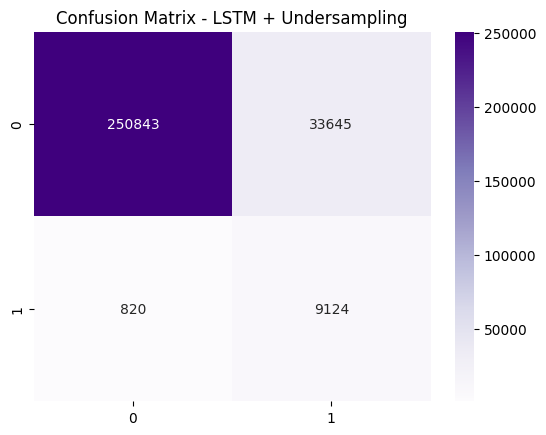

In [25]:
#Evaluasi LSTM + Undersampling
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
X_test_3d = X_test_2d.reshape((X_test_2d.shape[0], 1, X_test_2d.shape[1]))
y_pred_prob_under = model_under.predict(X_test_3d).flatten()
y_pred_under = (y_pred_prob_under > 0.5).astype(int)

print("=== LSTM + Undersampling ===")
print(classification_report(y_test_under, y_pred_under))
print("ROC AUC:", roc_auc_score(y_test_under, y_pred_prob_under))

sns.heatmap(confusion_matrix(y_test_under, y_pred_under), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - LSTM + Undersampling")
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
# LSTM + Feature Selection (RF)
# Feature selection dengan Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Ambil 10 fitur terpenting
importances = rf.feature_importances_
top_n = 10
top_features_idx = np.argsort(importances)[::-1][:top_n]
top_features = X.columns[top_features_idx].tolist()

print("Top Features:", top_features)


In [ ]:
# Gunakan top features dari RF
X_fs = df[top_features].apply(pd.to_numeric, errors='coerce').fillna(0)

# Normalisasi
X_fs_scaled = scaler.fit_transform(X_fs)

# Reshape untuk LSTM
X_fs_reshaped = X_fs_scaled.reshape((X_fs_scaled.shape[0], 1, X_fs_scaled.shape[1]))

# Split data
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(
    X_fs_reshaped, y, test_size=0.2, stratify=y, random_state=42
)

# Model LSTM
model_fs = Sequential()
model_fs.add(LSTM(64, input_shape=(X_train_fs.shape[1], X_train_fs.shape[2])))
model_fs.add(Dense(1, activation='sigmoid'))

model_fs.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop_fs = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history_fs = model_fs.fit(
    X_train_fs, y_train_fs,
    epochs=35,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop_fs],
    verbose=2
)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi probabilitas dan klasifikasi
y_pred_prob_fs = model_fs.predict(X_test_fs).flatten()
y_pred_fs = (y_pred_prob_fs > 0.5).astype(int)

# Evaluasi
print("=== LSTM + Feature Selection (RF) ===")
print(classification_report(y_test_fs, y_pred_fs))
print("ROC AUC:", roc_auc_score(y_test_fs, y_pred_prob_fs))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_fs, y_pred_fs), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - LSTM + RF Feature Selection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()